`Last edit on Mar 18 2024 with QuantumClifford 0.9.0 and Julia 1.10.2`

In [1]:
using Revise
using QuantumClifford
using QuantumClifford.Experimental.NoisyCircuits
using Plots      # Makie is a good alternative plotting library
using Quantikz
using ProgressMeter
using BenchmarkTools

The perturbative expansion code supports symbolic calculation. Simply use one of the many symbolic packages in Julia and set the various parameters of interest to symbolic values instead of numeric ones. Here we show an example of a typical purification circuit that uses various computer algebra system available in Julia.

The circuit we will study is:

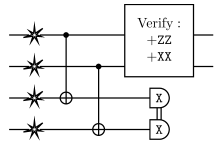

In [2]:
good_bell_state = S"XX
                    ZZ"
initial_state = MixedDestabilizer(good_bell_state⊗good_bell_state)

g1 = sCNOT(1,3) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = sCNOT(2,4) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([sMX(3),sMX(4)]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = 0.1 # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v] # Drawing the circuit out can be a bit slow as it uses LaTeX

## If you want to use `Symbolics`

In [3]:
using Symbolics
@variables e
unity = one(e);

In [4]:
good_bell_state = S"XX
                    ZZ"
initial_state = MixedDestabilizer(good_bell_state⊗good_bell_state)

g1 = sCNOT(1,3) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = sCNOT(2,4) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([sMX(3),sMX(4)]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = 3e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{CircuitStatus, Num} with 3 entries:
  true_success:CircuitStatus(1)  => (1 - 3e)^4 + 2e*((1 - 3e)^3)
  failure:CircuitStatus(3)       => 4e*((1 - 3e)^3)
  false_success:CircuitStatus(2) => 6e*((1 - 3e)^3)

In [5]:
@benchmark petrajectories(initial_state, circuit, branch_weight=unity)

BenchmarkTools.Trial: 6633 samples with 1 evaluation.
 Range (min … max):  631.701 μs …  13.019 ms  ┊ GC (min … max): 0.00% … 92.65%
 Time  (median):     694.707 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   748.245 μs ± 508.144 μs  ┊ GC (mean ± σ):  4.83% ±  6.63%

     ▁█  ▄▁  ▁                                                   
  ▃▃▂██▇▅██▆▇█▆▄▅▆▄▄▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂ ▃
  632 μs           Histogram: frequency by time         1.05 ms <

 Memory estimate: 260.19 KiB, allocs estimate: 5613.

In [6]:
# How to evaluate numerically
substitute(pe_symbolic[true_success_stat], Dict(e=>0.1))

0.3086999999999999

## If you want to use `AbstractAlgebra`

In [7]:
using AbstractAlgebra # Consider using Nemo.jl which can be much faster while having the same interfaces
R, (e,) = polynomial_ring(RealField, ["e"])
unity = R(1);

In [8]:
good_bell_state = S"XX
                    ZZ"
initial_state = MixedDestabilizer(good_bell_state⊗good_bell_state)

g1 = sCNOT(1,3) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = sCNOT(2,4) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([sMX(3),sMX(4)]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = 3e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{CircuitStatus, AbstractAlgebra.Generic.MPoly{BigFloat}} with 3 entries:
  true_success:CircuitStatus(1)  => 27.0*e^4 - 54.0*e^3 + 36.0*e^2 - 10.0*e + 1
  failure:CircuitStatus(3)       => -108.0*e^4 + 108.0*e^3 - 36.0*e^2 + 4.0*e
  false_success:CircuitStatus(2) => -162.0*e^4 + 162.0*e^3 - 54.0*e^2 + 6.0*e

In [9]:
@benchmark petrajectories(initial_state, circuit, branch_weight=unity)

BenchmarkTools.Trial: 6821 samples with 1 evaluation.
 Range (min … max):  585.893 μs …   9.417 ms  ┊ GC (min … max): 0.00% … 90.27%
 Time  (median):     657.003 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   728.558 μs ± 596.243 μs  ┊ GC (mean ± σ):  7.02% ±  7.90%

    ▃▅█▇▅                                                        
  ▃▄██████▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂ ▃
  586 μs           Histogram: frequency by time          1.4 ms <

 Memory estimate: 358.09 KiB, allocs estimate: 7016.

In [10]:
# How to evaluate numerically
pe_symbolic[true_success_stat](0.1)

0.30870000000000000209472196532889398667975910939276218414306640625

## If you want to use `SymPy`

In [11]:
using SymPy
e = Sym("e")
unity = Sym(1);

In [12]:
good_bell_state = S"XX
                    ZZ"
canonicalize_rref!(good_bell_state)
initial_state = MixedDestabilizer(good_bell_state⊗good_bell_state)

g1 = sCNOT(1,3) # CNOT between qubit 1 and qubit 3 (both with Alice)
g2 = sCNOT(2,4) # CNOT between qubit 2 and qubit 4 (both with Bob)
m = BellMeasurement([sMX(3),sMX(4)]) # Bell measurement on qubit 3 and 4
v = VerifyOp(good_bell_state,[1,2]) # Verify that qubit 1 and 2 indeed form a good Bell pair
epsilon = 3e # The error rate
n = NoiseOpAll(UnbiasedUncorrelatedNoise(epsilon))

# This circuit performs a depolarization at rate `epsilon` to all qubits,
# then bilater CNOT operations
# then a Bell measurement
# followed by checking whether the final result indeed corresponds to the correct Bell pair.
circuit = [n,g1,g2,m,v]

pe_symbolic = petrajectories(initial_state, circuit, branch_weight=unity) # perturbative expansion

Dict{CircuitStatus, Sym{PyCall.PyObject}} with 3 entries:
  true_success:CircuitStatus(1)  => 2.0*e*(1 - 3*e)^3 + 1.0*(1 - 3*e)^4
  failure:CircuitStatus(3)       => 4.0*e*(1 - 3*e)^3
  false_success:CircuitStatus(2) => 6.0*e*(1 - 3*e)^3

In [13]:
@benchmark petrajectories(initial_state, circuit, branch_weight=unity)

BenchmarkTools.Trial: 1454 samples with 1 evaluation.
 Range (min … max):  2.776 ms … 54.780 ms  ┊ GC (min … max): 0.00% … 45.97%
 Time  (median):     3.006 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.396 ms ±  3.603 ms  ┊ GC (mean ± σ):  3.56% ±  3.27%

     ▆█ ▁▂                                                    
  ▄▅▄██▇██▆▅▆▄▃▃▃▃▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▂▂▂▂▁▂▁▁▁▂▂▂▂ ▃
  2.78 ms        Histogram: frequency by time        4.82 ms <

 Memory estimate: 271.91 KiB, allocs estimate: 5914.

In [14]:
# How to evaluate numerically
pe_symbolic[true_success_stat].subs(e,0.1)

0.308700000000000

## Comparison to numeric result

In [15]:
true_success_symbolic = pe_symbolic[true_success_stat]

               3                4
2.0⋅e⋅(1 - 3⋅e)  + 1.0⋅(1 - 3⋅e) 

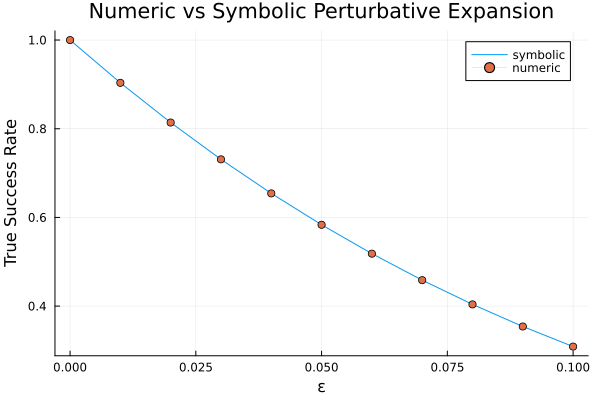

In [16]:
es_num = 0:0.01:0.1
symbolic_evaluations = [Float64(true_success_symbolic.subs(e,e_num)) for e_num in es_num]

numeric_evaluations = []
for epsilon in es_num
    n = NoiseOpAll(UnbiasedUncorrelatedNoise(3epsilon))
    circuit = [n,g1,g2,m,v]
    pe_symbolic = petrajectories(initial_state, circuit)
    push!(numeric_evaluations, pe_symbolic[true_success_stat])
end

plot(es_num, symbolic_evaluations, label="symbolic")
plot!(es_num, numeric_evaluations, line=false, marker=true, label="numeric")
plot!(xlabel="ε", ylabel="True Success Rate", title="Numeric vs Symbolic Perturbative Expansion")

## Reproducibility information

In [17]:
versioninfo()
using Pkg
Pkg.status("QuantumClifford")
Pkg.status("Symbolics")
Pkg.status("AbstractAlgebra")
Pkg.status("SymPy")

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Status `~/Documents/ScratchSpace/quantumjulia/Project.toml`
  [0525e862] QuantumClifford v0.8.21 `QuantumClifford.jl`
Status `~/Documents/ScratchSpace/quantumjulia/Project.toml`
⌃ [0c5d862f] Symbolics v5.22.1
Info Packages marked with ⌃ have new versions available and may be upgradable.
Status `~/Documents/ScratchSpace/quantumjulia/Project.toml`
  [c3fe647b] AbstractAlgebra v0.40.3
Status `~/Documents/ScratchSpace/quantumjulia/Project.toml`
  [24249f21] SymPy v2.0.1
